# Introduction to Natural Language Processing (1) 

## Lab03

In [1]:
import pandas as pd
import datasets as ds
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as SKLogisticRegression

import sys
import os

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import torch
import torch.nn as nn
import torch.nn.functional as F

parent_dir = os.path.dirname(os.getcwd())
sys.path.append(str(parent_dir))

from scripts import data
from scripts import features
from scripts.logistic_regression.model import LogisticRegression
from scripts.logistic_regression import lr_methods, scikit_learn_lr

/Users/francois.soulier/miniconda/envs/SCIA/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(


## Features (6 points)

For every given text, we want to generate a vector with the features seen in class.

**(6 points)** Code the following features:
* 1 if "no" appears in the document, 0 otherwise.
* The count of first and second pronouns in the document.
* 1 if "!" is in the document, 0 otherwise.
* Log(word count in the document).
* Number of words in the document which are in the positive lexicon.
* Number of words in the document which are in the negative lexicon.
* **\[Bonus\]** Add another feature of your choice.

For positive and negative lexicons, you can use the resources provided by [VADER sentiment](https://github.com/cjhutto/vaderSentiment). Look for the `vader_lexicon.txt` file and consider positive word if they score above a certain threshold (for example 1) and negative word if they score below a certain threshold (for example -1). Feel free to use another lexicon if you find one, but make sure you document your choice.


### Tips

* Don't forget to use a similar pre-treatment as the one you used for the previous lab.
* Beware that words in the VADER dictionary are not lemmatized or stemmed. Do not use these pretreatments here.
* When checking for occurences of "no" or pronouns, split the text into token. Just using `"no" in text` would return true if the word "notable" is in your text.


### Loading datasets

In [2]:
splits = ds.get_dataset_split_names('imdb')
train_ds, test_ds = data.load_datasets(splits=splits[:2])

Found cached dataset imdb (/Users/francois.soulier/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)
Found cached dataset imdb (/Users/francois.soulier/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


### Features extraction

Import lexicon

In [3]:
nltk.download('vader_lexicon')
sid: SentimentIntensityAnalyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/francois.soulier/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Apply feature extraction on an example

In [4]:
features.get_features("I am You We  not happy NO !", sid=sid)

[1, 2, 1, 1, 2.0794415416798357, 1, 1, 0]

Apply features extraction on both `training` and `testing` datasets.

In [5]:
df_train: pd.DataFrame = features.add_features(train_ds, sid=sid)
df_test: pd.DataFrame = features.add_features(test_ds, sid=sid)

# Result example
df_train.head()

,no,first_pronouns,second_pronouns,exclamation,log_word_count,positive,negative,label,third_person
0,1,6,0,0,5.641907,7,5,0,8
1,1,1,1,0,5.365976,3,4,0,3
2,1,0,0,0,4.465908,3,3,0,4
3,0,2,1,0,4.736198,5,3,0,1
4,0,8,1,1,5.680173,4,11,0,9


Split the `training` dataset into a training and a validation dataset (using 10 to 20% of the training set as validation).

In [6]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop(columns=["label"]), df_train["label"], test_size=0.2, random_state=42)

## Logistic regression classifier (6 points)

The `logistic_regression_pytorch.ipynb` notebook, in the same directory, shows how to train a logistic regression classifier using PyTorch on a dummy dataset.

* **(3 points)** Adapt the code by adding your feature extractor and train a classifier.
  * For training, don't use the test set as validation. Instead, split the training set into a training and a validation set (use 10 to 20% of the training set as validation).
* **(1 point)** Evaluate your classifier in terms of accuracy for the training, validation, and test set.
* **(1 point)** Look at the weights of your classifier. Which features seems to play most for both classes?
* **\[Bonus\]** The parameter `weight_decay` of the [SGD optimizer](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) corresponds to the L2 penalty. Try playing with this value and explain how it influence the model's weights.
* **(1 point)** Take two wrongly classified samples in the test set and try explaining why the model was wrong.
* **\[Bonus\]** Train logistic regression classifier using the [scikit-learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). How does it compare with the PyTorch version?


Define model, loss function and optimizer function

In [7]:
model = LogisticRegression(8, 1)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1.0)

Model training

In [8]:
train_losses, test_losses, torch_training_duration = lr_methods.fit(model, optimizer, criterion, X_train, y_train, X_val, y_val)

tensor(1.6595, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6004, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5988, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5990, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5992, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5992, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5992, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5992, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5992, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5992, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Training time: 1.17 seconds


Display `training` and `validation` losses

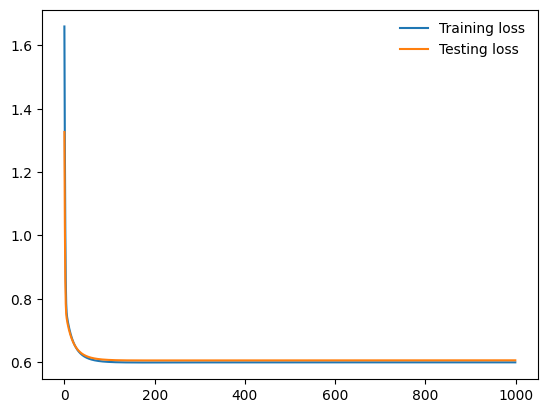

In [9]:
# Plot the losses
lr_methods.display_losses(training=train_losses, testing=test_losses)

Display `training`, `validation` and `test` accuracies

In [10]:
X_test, y_test = df_test.drop(columns=["label"]), df_test["label"]

lr_methods.evaluate(type='Training', model=model, X=X_train, y=y_train)
lr_methods.evaluate(type='Validation', model=model, X=X_val, y=y_val)
lr_methods.evaluate(type='Test', model=model, X=X_test, y=y_test)

Training accuracy: 69.94%
Validation accuracy: 69.48%
Test accuracy: 70.11%


* **(1 point)** Look at the weights of your classifier. Which features seems to play most for both classes?

In [11]:
# Print the 2 biggest weights of the features for both classes.
print(model.linear.weight[0])

print("\nPositive class\n")
print(model.linear.weight[0].topk(2))

# For the positive class, the number of positive words and the presence of exclamation marks are the most important features.
print("\nNegative class\n")
print(model.linear.weight[0].topk(2, largest=False))

tensor([-0.0189, -0.0399, -0.0060, -0.0041, -0.0182,  0.1124, -0.1334,  0.0052],
       grad_fn=<SelectBackward0>)

Positive class

torch.return_types.topk(
values=tensor([0.1124, 0.0052], grad_fn=<TopkBackward0>),
indices=tensor([5, 7]))

Negative class

torch.return_types.topk(
values=tensor([-0.1334, -0.0399], grad_fn=<TopkBackward0>),
indices=tensor([6, 1]))


For the negative class, the number of negative words and the number of first person pronouns are the most important features.

* **\[Bonus\]** The parameter `weight_decay` of the [SGD optimizer](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) corresponds to the L2 penalty. Try playing with this value and explain how it influence the model's weights.

The **weight_decay** parameter adds a L2 penalty (also known as ridge regularization) to the cost. It can reduce the impact of large coefficients and encourage the model to have smaller and more balanced coefficients, which can lead to better generalization performance and prevent overfitting.

The strength of the L2 penalty is controlled by the lambda hyperparameter. Increasing the value of lambda increases the strength of the penalty and results in smaller coefficients, which can reduce overfitting but may also reduce the model's ability to capture complex relationships in the data.

However, it is important to choose an appropriate value of lambda that balances the trade-off between bias and variance, as a too strong penalty can lead to underfitting and a too weak penalty can lead to overfitting.

* **(1 point)** Take two wrongly classified samples in the test set and try explaining why the model was wrong.

#### First wrongly classified sample

In [12]:
# First wrong prediction
print(df_test.iloc[0])

no                 0.000000
first_pronouns     3.000000
second_pronouns    1.000000
exclamation        1.000000
log_word_count     5.438079
positive           8.000000
negative           7.000000
label              0.000000
third_person       5.000000
Name: 0, dtype: float64


The model predicted a positive label, but the true label is negative. 
The model predicted a positive label because the number of positive words is higher than the number of negative words.
However, the number of first person pronouns is higher than the number of exclamation marks.

#### Second wrongly classified sample

In [13]:
# Second wrong prediction
print(df_test.iloc[1])

no                  0.000000
first_pronouns      1.000000
second_pronouns     4.000000
exclamation         0.000000
log_word_count      5.347108
positive           14.000000
negative           13.000000
label               0.000000
third_person        1.000000
Name: 1, dtype: float64


Again, the model predicted a positive label, but the true label is negative. 
It may have returned a positive label because the number of positive words is higher than the number of negative words.

The model predicted a positive label because the number of positive words is higher than the number of negative words.

* **\[Bonus\]** Train logistic regression classifier using the [scikit-learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). How does it compare with the PyTorch version?


#### Training

In [14]:
# Add a L2 penalty to the logistic regression classifier
model: SKLogisticRegression = scikit_learn_lr.model(penalty='l2', C=0.001)

# Train the model on the training set
sk_training_duration = scikit_learn_lr.fit(model, X_train, y_train)

Training time: 0.07 seconds


#### Evaluation

In [15]:
# Evaluate the model on the training set
_ = scikit_learn_lr.evaluate(model, X_train, y_train, type="Training")

# Evaluate the model on the validation set
scikit_learn_lr.evaluate(model, X_val, y_val, type="Validation")

# Split the test_df into X_test and y_test
_ = X_test = df_test.drop(columns=["label"])
_ = y_test = df_test["label"]

# Evaluate the model on the test set
_ = scikit_learn_lr.evaluate(model, X_test, y_test, type="Test")

Training accuracy: 69.91%
Validation accuracy: 69.68%
Test accuracy: 70.19%


The accuracy of the sklearn logistic regression classifier is comparable to the accuracy of the PyTorch model, as both models have an accuracy approximately the same accuracy on all three datasets.

In [16]:
# Compare the training duration of the PyTorch and Scikit-Learn models as ratio
ratio: float = torch_training_duration / sk_training_duration
print(f"The scikit-learn model perform {ratio:.2f} times faster than the PyTorch model.")

The scikit-learn model perform 16.96 times faster than the PyTorch model.


An interesting observation is that the sklearn model has a much shorter training duration shorter than the PyTorch model, which can be an important factor when training a model on a large dataset.
